In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import gc

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from General import *
from ReadingTheDataUtils import *
from Classifiers import *
from PreproccesUtils import *
from PerformanceEvalutionUtils import *

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

2019-12-29 16:51:08,256 - DEBUG - MainThread - Classifiers - <module> - First time initialize logger!


In [4]:
from pathlib import Path

ROOT_PATH = Path('..')
SRC_PATH = Path('.')
DATA_PATH = ROOT_PATH / 'data'
CSV_PATH = DATA_PATH / 'ExtraSensory.per_uuid_features_labels'
CSV_SUFFIX = '.features_labels.csv'
ORIGINAL_LABLES_CSV_PATH = DATA_PATH / 'ExtraSensory.per_uuid_original_labels'
ORIGINAL_LABLES_CSV_SUFFIX = '.original_labels.csv'
FOLD_PATH = DATA_PATH / 'cv_5_folds'

In [5]:
%%time
data = pd.read_csv(DATA_PATH / 'dataset.csv', index_col='uuid')

Wall time: 14 s


In [6]:
data['label'] = data['label'].astype('category')

for col in data.columns:
    if col.startswith('discrete'):
        data[col] = data[col].astype('category')

In [7]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 377346 entries, 00EABED2-271D-49D8-B599-1D4A09240601 to FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF
Data columns (total 228 columns):
raw_acc:magnitude_stats:mean                                               377056 non-null float64
raw_acc:magnitude_stats:std                                                377056 non-null float64
raw_acc:magnitude_stats:moment3                                            377056 non-null float64
raw_acc:magnitude_stats:moment4                                            377056 non-null float64
raw_acc:magnitude_stats:percentile25                                       377056 non-null float64
raw_acc:magnitude_stats:percentile50                                       377056 non-null float64
raw_acc:magnitude_stats:percentile75                                       377056 non-null float64
raw_acc:magnitude_stats:value_entropy                                      377056 non-null float64
raw_acc:magnitude_stats:time_entropy

In [8]:
train_folds_list, test_folds_list = get_folds_list(FOLD_PATH)

### Split to train and test

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from MixedColumnTransformer import MixedColumnTransformer, ColumnTypeEnum

from GaussianAndBernoulliNB import GaussianAndBernoulliNB
from sklearn.naive_bayes import BernoulliNB, GaussianNB



def get_single_pre_pipe():
    transormers = [
        ('ohe', OneHotEncoder(sparse=False), ColumnTypeEnum.CATEGORY),
        ('scaler', StandardScaler(), ColumnTypeEnum.NUMERIC),
        ('SimpleImputerCat', SimpleImputer(strategy="most_frequent"), ColumnTypeEnum.CATEGORY),
        ('SimpleImputerNum', SimpleImputer(strategy='mean'), ColumnTypeEnum.NUMERIC)
    ]
    
    pipe = Pipeline([
        ("mixed_column_transformer", MixedColumnTransformer(transormers))
    ])
    
    return pipe


for train_fold_lst, test_fold_lst in zip(train_folds_list, test_folds_list):
    gc.collect()

    train_fold_df, test_fold_df = get_folds_train_and_test(data, train_fold_lst, test_fold_lst)
    
    X_fold_train, X_fold_test, y_fold_train, y_fold_test = \
            split_fold_data_to_features_and_labels(train_fold_df, test_fold_df)
        
    pipe = get_pre_pipe()
    
    X_train = pipe.fit_transform(X_fold_train)
    y_train = y_fold_train
    X_test = pipe.transform(X_fold_test)
    y_test = y_fold_test
    
    cat_cols_indices = pipe['mixed_column_transformer'].cat_cols_indices_
    num_cols_indices = pipe['mixed_column_transformer'].num_cols_indices_
    
    break

11

### Train

In [10]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from GaussianAndBernoulliNB import GaussianAndBernoulliNB


bernoulli = BernoulliNB()
bernoulli.fit(X_train[:, cat_cols_indices], y_train)

gaussian_bernoulli = GaussianAndBernoulliNB(cat_cols_indices, num_cols_indices)
gaussian_bernoulli.fit(X_train, y_train)

gnb_grid = GaussianNB()
gnb_grid.fit(X_train[:, num_cols_indices], y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

GaussianAndBernoulliNB(bernoulli_params=None,
                       cat_cols_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
                       gaussian_params=None,
                       num_cols_indices=array([ 65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  8...
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       

GaussianNB(priors=None, var_smoothing=1e-09)

# Results

In [11]:
bern_pred = bernoulli.predict(X_test[:, cat_cols_indices])
gaussian_pred = gnb_grid.predict(X_test[:, num_cols_indices])
mixture_pred = gaussian_bernoulli.predict(X_test)

### Compare modle scores

In [12]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [13]:
print(classification_report(y_test, bern_pred))

              precision    recall  f1-score   support

           0       0.24      0.28      0.26     14966
           1       0.04      0.03      0.03      2246
           2       0.01      0.81      0.02       158
           3       0.02      0.64      0.03       187
           4       0.39      0.23      0.29     33630
           5       0.16      0.05      0.08     13872

    accuracy                           0.20     65059
   macro avg       0.14      0.34      0.12     65059
weighted avg       0.29      0.20      0.23     65059



In [14]:
print(classification_report(y_test, gaussian_pred))

              precision    recall  f1-score   support

           0       0.34      0.05      0.09     14966
           1       0.04      0.77      0.07      2246
           2       0.01      0.16      0.01       158
           3       0.03      0.63      0.05       187
           4       0.71      0.15      0.25     33630
           5       0.56      0.09      0.15     13872

    accuracy                           0.14     65059
   macro avg       0.28      0.31      0.11     65059
weighted avg       0.57      0.14      0.19     65059



In [15]:
print(classification_report(y_test, mixture_pred))

              precision    recall  f1-score   support

           0       0.34      0.05      0.09     14966
           1       0.04      0.83      0.08      2246
           2       0.01      0.19      0.01       158
           3       0.03      0.65      0.05       187
           4       0.64      0.17      0.26     33630
           5       0.51      0.11      0.18     13872

    accuracy                           0.15     65059
   macro avg       0.26      0.33      0.11     65059
weighted avg       0.52      0.15      0.20     65059



### Compare model distribution

In [16]:
y_counts = np.bincount(y_test)
bern_counts = np.bincount(bern_pred)
guassian_counts = np.bincount(gaussian_pred)
mixture_counts = np.bincount(mixture_pred)

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

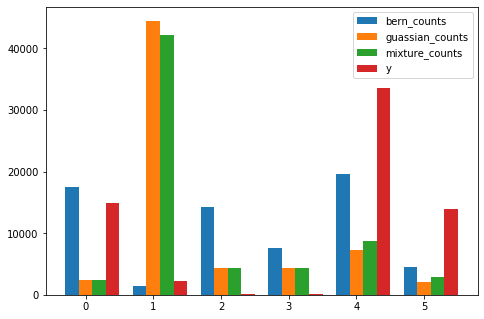

In [17]:
#plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.arange(y_counts.shape[0])

ax.bar(X - 0.20, bern_counts, width=0.20)
ax.bar(X + 0.00, guassian_counts, width=0.20)
ax.bar(X + 0.20, mixture_counts, width=0.20)
ax.bar(X + 0.40, y_counts, width=0.20)

ax.legend(['bern_counts', 'guassian_counts', 'mixture_counts', 'y'])

plt.show()

# Compare model acceptnes

In [18]:
mixture_and_gaussian_accept = (mixture_pred == gaussian_pred) & (mixture_pred == y_test) & (gaussian_pred == y_test) 
mixture_and_bern_accept = (mixture_pred == bern_pred) & (mixture_pred == y_test) & (bern_pred == y_test) 

In [19]:
X_fold_test[mixture_and_bern_accept].shape

(737, 225)

In [20]:
X_fold_test[mixture_and_gaussian_accept].shape

(7904, 225)

In [21]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()

lr_clf = LogisticRegression(max_iter=1).fit(X_train[:, cat_cols_indices], y_train)
perm = PermutationImportance(lr_clf).fit(X_test[:, cat_cols_indices], y_test)
eli5.show_weights(perm)

Weight,Feature
0.0012 ± 0.0002,x52
0.0012 ± 0.0002,x51
0.0008 ± 0.0002,x61
0.0008 ± 0.0002,x54
0.0007 ± 0.0001,x57
0.0007 ± 0.0002,x16
0.0007 ± 0.0001,x17
0.0005 ± 0.0002,x62
0.0004 ± 0.0002,x42
0.0004 ± 0.0004,x45


In [28]:
np.argsort(perm.feature_importances_)

array([35, 34, 20,  5, 21,  8, 37, 36, 13,  9, 14, 40, 39,  6, 41,  4, 22,
       25, 24, 60, 63, 23, 56, 38,  7, 50, 10, 64, 11, 53, 29, 48, 46, 47,
       32, 31, 28, 27, 19, 18,  3, 12, 33, 15, 26,  2, 49,  1, 30, 44,  0,
       59, 43, 55, 58, 45, 42, 62, 17, 16, 57, 54, 61, 51, 52],
      dtype=int64)

In [30]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf = RandomForestClassifier(n_estimators=1).fit(X_train[:, cat_cols_indices], y_train)
perm = PermutationImportance(rf_clf).fit(X_test[:, cat_cols_indices], y_test)
eli5.show_weights(perm)

Weight,Feature
0.0192 ± 0.0010,x5
0.0180 ± 0.0009,x16
0.0170 ± 0.0008,x4
0.0145 ± 0.0008,x24
0.0109 ± 0.0006,x22
0.0080 ± 0.0003,x49
0.0076 ± 0.0012,x13
0.0074 ± 0.0005,x23
0.0054 ± 0.0008,x44
0.0052 ± 0.0005,x42


In [31]:
np.argsort(perm.feature_importances_)

array([20, 63, 64, 60, 37, 58, 61,  7, 21,  1, 17, 45, 28, 62, 14, 40,  9,
        2, 48, 33, 11, 27, 12, 18, 19, 47, 46, 38, 35, 26, 15, 32,  3, 53,
       59, 30, 29, 54, 31, 36, 57, 10, 25, 52, 51, 41,  0, 56,  8, 43,  6,
       55, 34, 39, 50, 42, 44, 23, 13, 49, 22, 24,  4, 16,  5],
      dtype=int64)

In [32]:
transormers = [
        ('ohe', OneHotEncoder(sparse=False), ColumnTypeEnum.CATEGORY),
        ('scaler', StandardScaler(), ColumnTypeEnum.NUMERIC),
        ('SimpleImputerCat', SimpleImputer(strategy="most_frequent"), ColumnTypeEnum.CATEGORY),
        ('SimpleImputerNum', SimpleImputer(strategy='mean'), ColumnTypeEnum.NUMERIC)
]
    
pipe = Pipeline([
    ("mixed_column_transformer", MixedColumnTransformer(transormers)),
    ("clf_model", RandomForestClassifier(n_estimators=1))
])

rf_clf = pipe.fit(X_train[:, cat_cols_indices], y_train)
perm = PermutationImportance(rf_clf).fit(X_test[:, cat_cols_indices], y_test)
eli5.show_weights(perm)

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

# =========================

In [43]:
groups = pd.Series(X_fold_train.index).astype('category').cat.codes

0          1
1          1
2          1
3          1
4          1
          ..
312282    47
312283    47
312284    47
312285    47
312286    47
Length: 312287, dtype: int8

In [65]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)

for train_index, test_index in gkf.split(X_fold_train, groups=ser.cat.codes):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_, X_test_ = X_fold_train.iloc[train_index], X_fold_train.iloc[test_index]
    
    for index in np.unique(X_train_.index):
        if index in np.unique(X_test_.index):
            raise Exception("")

TRAIN: [  6172   6173   6174 ... 312284 312285 312286] TEST: [     0      1      2 ... 303781 303782 303783]
TRAIN: [     0      1      2 ... 303781 303782 303783] TEST: [ 20512  20513  20514 ... 312284 312285 312286]
TRAIN: [     0      1      2 ... 312284 312285 312286] TEST: [  6172   6173   6174 ... 290515 290516 290517]
